Our goal is  to create movie recommendation system

importing libraries and downloading the data

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [79]:
movie_rating= pd.read_csv('movie.data', sep='\t',names=['user_id', 'item_id', 'rating', 'timestamp'])
movie_titles = pd.read_csv("Movie_Id_Titles")

In [9]:
movie_rating.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [10]:
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [80]:
movies= pd.merge(movie_rating,movie_titles,on='item_id')
movies.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [98]:
movies['user_id'].nunique()  #number of unique users

944

In [99]:
movies['item_id'].nunique() #number of unique items

1682

<AxesSubplot:>

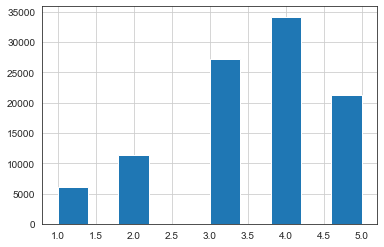

In [22]:
movies['rating'].hist()

determining average ratings movies get

In [100]:
avg_rate=movies.groupby('title')['rating'].mean()

In [101]:
movies= pd.merge(movies,avg_rate,on='title')

In [102]:
movies.rename(columns={'rating_x':'rating','rating_y':'avg_rate'},inplace=True)

<AxesSubplot:>

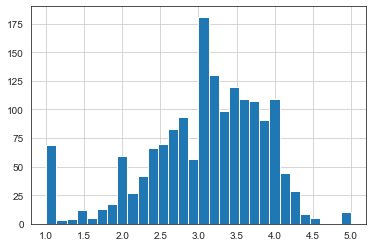

In [70]:
avg_rate.hist(bins=30)

determining number of ratings movies get

In [103]:
rate_count=movies.groupby('title')['rating'].count()

In [104]:
movies= pd.merge(movies,rate_count,on='title')

In [105]:
movies.rename(columns={'rating_x':'rating','rating_y':'rate_count'},inplace=True)

<AxesSubplot:>

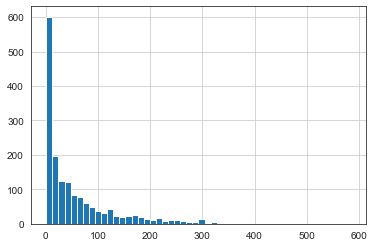

In [71]:
rate_count.hist(bins=50)

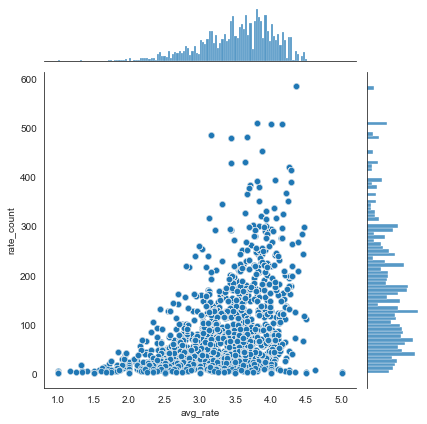

In [107]:
sns.jointplot(x='avg_rate',y='rate_count',data=movies,alpha=0.5)

In [106]:
movies.head()

,user_id,item_id,rating,timestamp,title,avg_rate,rate_count
0,0,50,5,881250949,Star Wars (1977),4.359589,584
1,290,50,5,880473582,Star Wars (1977),4.359589,584
2,79,50,4,891271545,Star Wars (1977),4.359589,584
3,2,50,5,888552084,Star Wars (1977),4.359589,584
4,8,50,5,879362124,Star Wars (1977),4.359589,584


### Memory Based Collabortive Filtering


Creating pivot tables

In [148]:
user_item=pd.pivot_table(movies, values='rating', index='user_id', columns='title')
user_item.fillna(0,inplace=True)

In [149]:
user_item

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finding pairwise distances

In [151]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(user_item, metric='cosine')
item_similarity = pairwise_distances(user_item.T, metric='cosine')

In [152]:
#sum of absolute value of similarities between items
abs_item_similarity=np.abs(item_similarity).sum(axis=1)
# sum of absolute value of similarities between users
abs_user_similarity=np.array([np.abs(user_similarity).sum(axis=1)]).T

### item-user 

average rating by our user+(sum of ratings for our item by all users (corrected by average rate by that user) weighted by similarity between users/ sum of absolute value of similarities between users

In [153]:
mean_ratings = user_item.mean(axis=1)
ratings_diff=user_item-mean_ratings[:, np.newaxis]#np.newaxis turns array to vector

<ipython-input-153-d4bcb74c79f8>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ratings_diff=user_item-mean_ratings[:, np.newaxis]#np.newaxis turns array to vector


In [154]:
user_prediction= mean_ratings[:, np.newaxis]+ user_similarity.dot(ratings_diff)/abs_user_similarity

<ipython-input-154-d7190ef29358>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  user_prediction= mean_ratings[:, np.newaxis]+ user_similarity.dot(ratings_diff)/abs_user_similarity


In [155]:
user_prediction

array([[-0.19178156, -0.20064647,  0.11564345, ..., -0.20042867,
        -0.18168457, -0.21139798],
       [ 0.41316573,  0.40587074,  0.69594214, ...,  0.40659662,
         0.41805579,  0.39552941],
       [-0.07143736, -0.07823743,  0.24559977, ..., -0.07934465,
        -0.05955649, -0.08990026],
       ...,
       [-0.14817889, -0.15638217,  0.1556521 , ..., -0.15720604,
        -0.13884381, -0.16728084],
       [ 0.0076182 ,  0.00113696,  0.31516178, ...,  0.0007851 ,
         0.01914288, -0.01048955],
       [ 0.16659873,  0.15999883,  0.44822394, ...,  0.1601746 ,
         0.17498429,  0.14945843]])

### item-item

sum of ratings for all items by our user weighted by similarity between items / sum of absolute value of similarities between items

In [156]:
item_prediction =user_item.dot(item_similarity) / abs_item_similarity 

In [157]:
item_prediction

,0,1,2,3,4,5,6,7,8,9,...,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.006518,0.006606,0.005067,0.004539,0.006404,0.005611,0.004770,0.003394,0.006530,0.005312,...,0.006710,0.006505,0.006394,0.003782,0.004540,0.005465,0.006198,0.006547,0.006285,0.006781
1,0.575706,0.583374,0.528821,0.494849,0.579666,0.524336,0.502765,0.445459,0.583263,0.533184,...,0.606340,0.581346,0.576367,0.456190,0.486805,0.534170,0.559142,0.589647,0.549176,0.600070
2,0.129569,0.137407,0.125350,0.127855,0.125562,0.119412,0.135650,0.125294,0.127398,0.133060,...,0.143962,0.133371,0.135631,0.128851,0.133374,0.135855,0.128361,0.134855,0.133032,0.137008
3,0.085212,0.089023,0.089181,0.089285,0.075612,0.084235,0.092067,0.088609,0.086230,0.090553,...,0.093043,0.085650,0.088306,0.092211,0.089475,0.089918,0.084566,0.090070,0.086145,0.090505
4,0.060866,0.063606,0.060408,0.061048,0.056135,0.058822,0.061945,0.058966,0.061158,0.062910,...,0.065019,0.060363,0.062354,0.061056,0.059673,0.061196,0.059957,0.063040,0.061199,0.064254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.119047,0.125913,0.103458,0.121061,0.119197,0.107866,0.121283,0.115639,0.124672,0.125283,...,0.132549,0.123762,0.123606,0.116963,0.116569,0.120485,0.120852,0.119717,0.122276,0.129484
940,0.215104,0.222596,0.201184,0.184163,0.213845,0.197755,0.192111,0.163602,0.217649,0.196787,...,0.229001,0.217516,0.218973,0.170587,0.190756,0.207042,0.211618,0.223569,0.215363,0.227405
941,0.051693,0.053476,0.046024,0.048367,0.050363,0.043277,0.049834,0.044155,0.053227,0.051654,...,0.056894,0.053422,0.052483,0.045932,0.047315,0.049979,0.048212,0.052814,0.050566,0.055494


### Model-based Collaborative Filtering

In [45]:
from surprise import Reader, Dataset, accuracy
from surprise import SVD, NMF
from surprise.model_selection import cross_validate,train_test_split

In [7]:
reader = Reader()

In [36]:
data = Dataset.load_from_df(movies[['user_id','item_id','rating']],reader)

In [39]:
trainset, testset = train_test_split(data, test_size=.25)

### singular value decomposition

In [12]:
model= SVD()

In [13]:
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9409  0.9420  0.9360  0.9328  0.9263  0.9356  0.0057  
MAE (testset)     0.7407  0.7417  0.7401  0.7335  0.7326  0.7377  0.0039  
Fit time          4.06    4.13    4.09    4.21    4.12    4.12    0.05    
Test time         0.14    0.20    0.12    0.12    0.12    0.14    0.03    


{'test_rmse': array([0.94089798, 0.94200421, 0.93600044, 0.93276152, 0.9262786 ]),
 'test_mae': array([0.7407351 , 0.74165959, 0.7401268 , 0.73352845, 0.73257204]),
 'fit_time': (4.0562803745269775,
  4.129735708236694,
  4.092965841293335,
  4.211654186248779,
  4.1166791915893555),
 'test_time': (0.14027976989746094,
  0.19530272483825684,
  0.11961674690246582,
  0.11608481407165527,
  0.11812949180603027)}

In [42]:
model.fit(trainset)

In [43]:
predictions = model.test(testset)

In [46]:
accuracy.rmse(predictions)

RMSE: 0.9456


0.9455656207980667

For example if we want to predict user 1's rate for item 2

In [ ]:
model.predict(uid=<1>, iid=<2>)

### non-negative matrix factorization

In [48]:
model2 = NMF()
cross_validate(model2, data, measures=['RMSE', 'MAE'], cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9696  0.9623  0.9574  0.9645  0.9620  0.9631  0.0040  
MAE (testset)     0.7615  0.7568  0.7531  0.7577  0.7564  0.7571  0.0027  
Fit time          4.83    4.88    4.76    4.69    4.79    4.79    0.06    
Test time         0.14    0.10    0.10    0.17    0.11    0.12    0.03    


{'test_rmse': array([0.96957048, 0.9623001 , 0.95736701, 0.96445484, 0.96200664]),
 'test_mae': array([0.76147082, 0.75683968, 0.75309999, 0.75770987, 0.75642778]),
 'fit_time': (4.830271005630493,
  4.877192735671997,
  4.756935119628906,
  4.687757730484009,
  4.788372278213501),
 'test_time': (0.1362316608428955,
  0.09826922416687012,
  0.09809517860412598,
  0.1676926612854004,
  0.10544180870056152)}

In [49]:
model2.fit(trainset)

In [50]:
predictions = model2.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9701


0.9700800352508314